In [1]:
import scanpy as sc
import seaborn as sns
from scipy.stats.stats import pearsonr
import numpy as np

/var/folders/lb/xhq_wzhs30l78s_s99z52_jh0000gq/T/ipykernel_17473/1492856737.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
dt = "dt/TF_SC_filtered_feature_bc_matrix"
adata = sc.read_10x_mtx(dt)

In [3]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False
)

In [5]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
sc.pp.scrublet(adata)

In [7]:
adata.obs["outlier_mt"] = adata.obs.pct_counts_mt > 20
adata.obs["outlier_total"] = adata.obs.total_counts > 100000
adata.obs["outlier_ngenes"] = adata.obs.n_genes_by_counts > 10000

print(
    "%u cells with high %% of mitochondrial genes"
    % (sum(adata.obs["outlier_mt"]))
)
print("%u cells with large total counts" % (sum(adata.obs["outlier_total"])))
print("%u cells with large number of genes" % (sum(adata.obs["outlier_ngenes"])))

203 cells with high % of mitochondrial genes
27 cells with large total counts
20 cells with large number of genes


In [8]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    7975
Name: count, dtype: int64

In [9]:
adata = adata[~adata.obs["outlier_mt"], :]
adata = adata[~adata.obs["outlier_total"], :]
adata = adata[~adata.obs["outlier_ngenes"], :]

In [10]:
adata = adata[~adata.obs["predicted_doublet"], :]

In [11]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/var/folders/lb/xhq_wzhs30l78s_s99z52_jh0000gq/T/ipykernel_17473/1526851425.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

In [13]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [14]:
sc.tl.pca(adata)
sc.pp.neighbors(adata,random_state=0)
sc.tl.umap(adata, random_state = 0)

/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
sc.tl.score_genes(adata, ["Mpz", "Prx", "Egr2", "Sox10",'Pou3f1'],score_name="SC_genes")

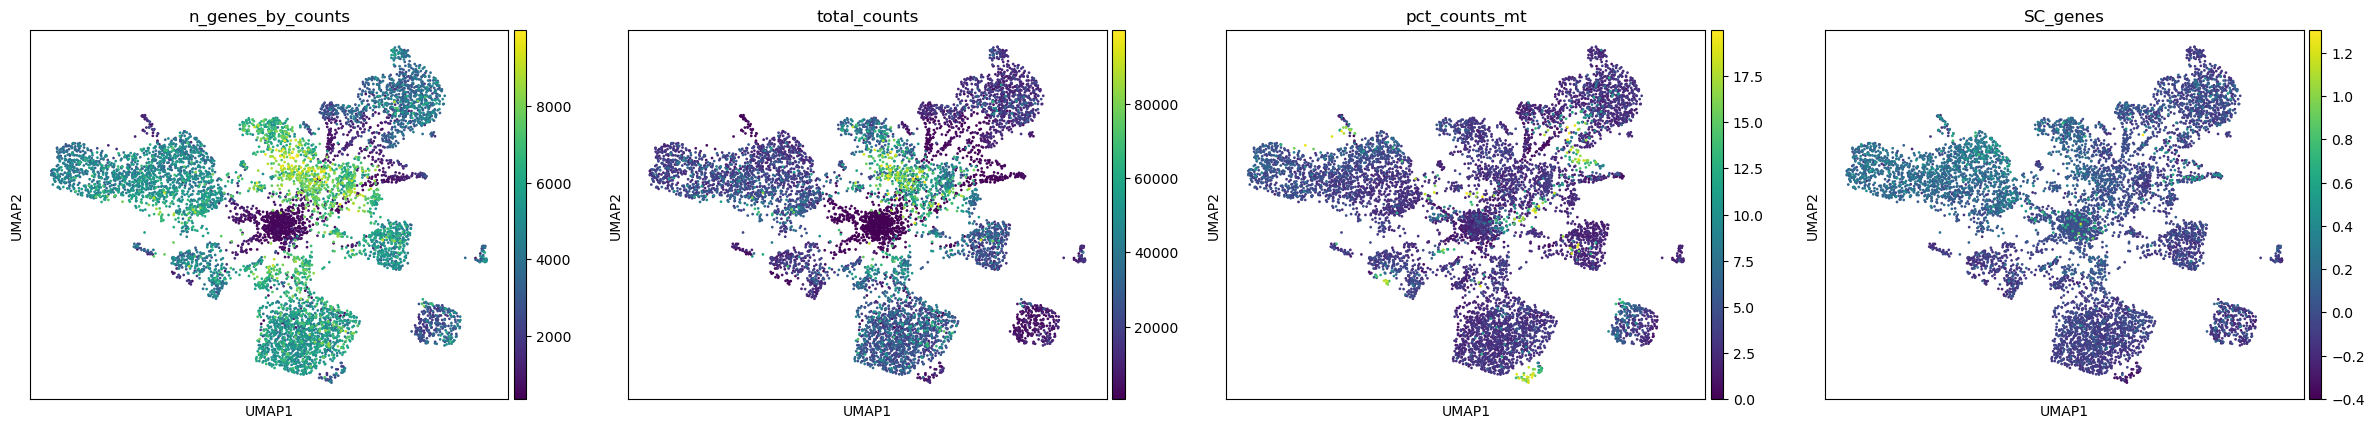

In [16]:
sc.pl.umap(adata,color = ["n_genes_by_counts", "total_counts", "pct_counts_mt","SC_genes"])

In [17]:
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_05")

/var/folders/lb/xhq_wzhs30l78s_s99z52_jh0000gq/T/ipykernel_17473/1346498408.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added="leiden_05")


In [18]:
sc.tl.leiden(adata, resolution=1, key_added="leiden")

In [19]:
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_01")

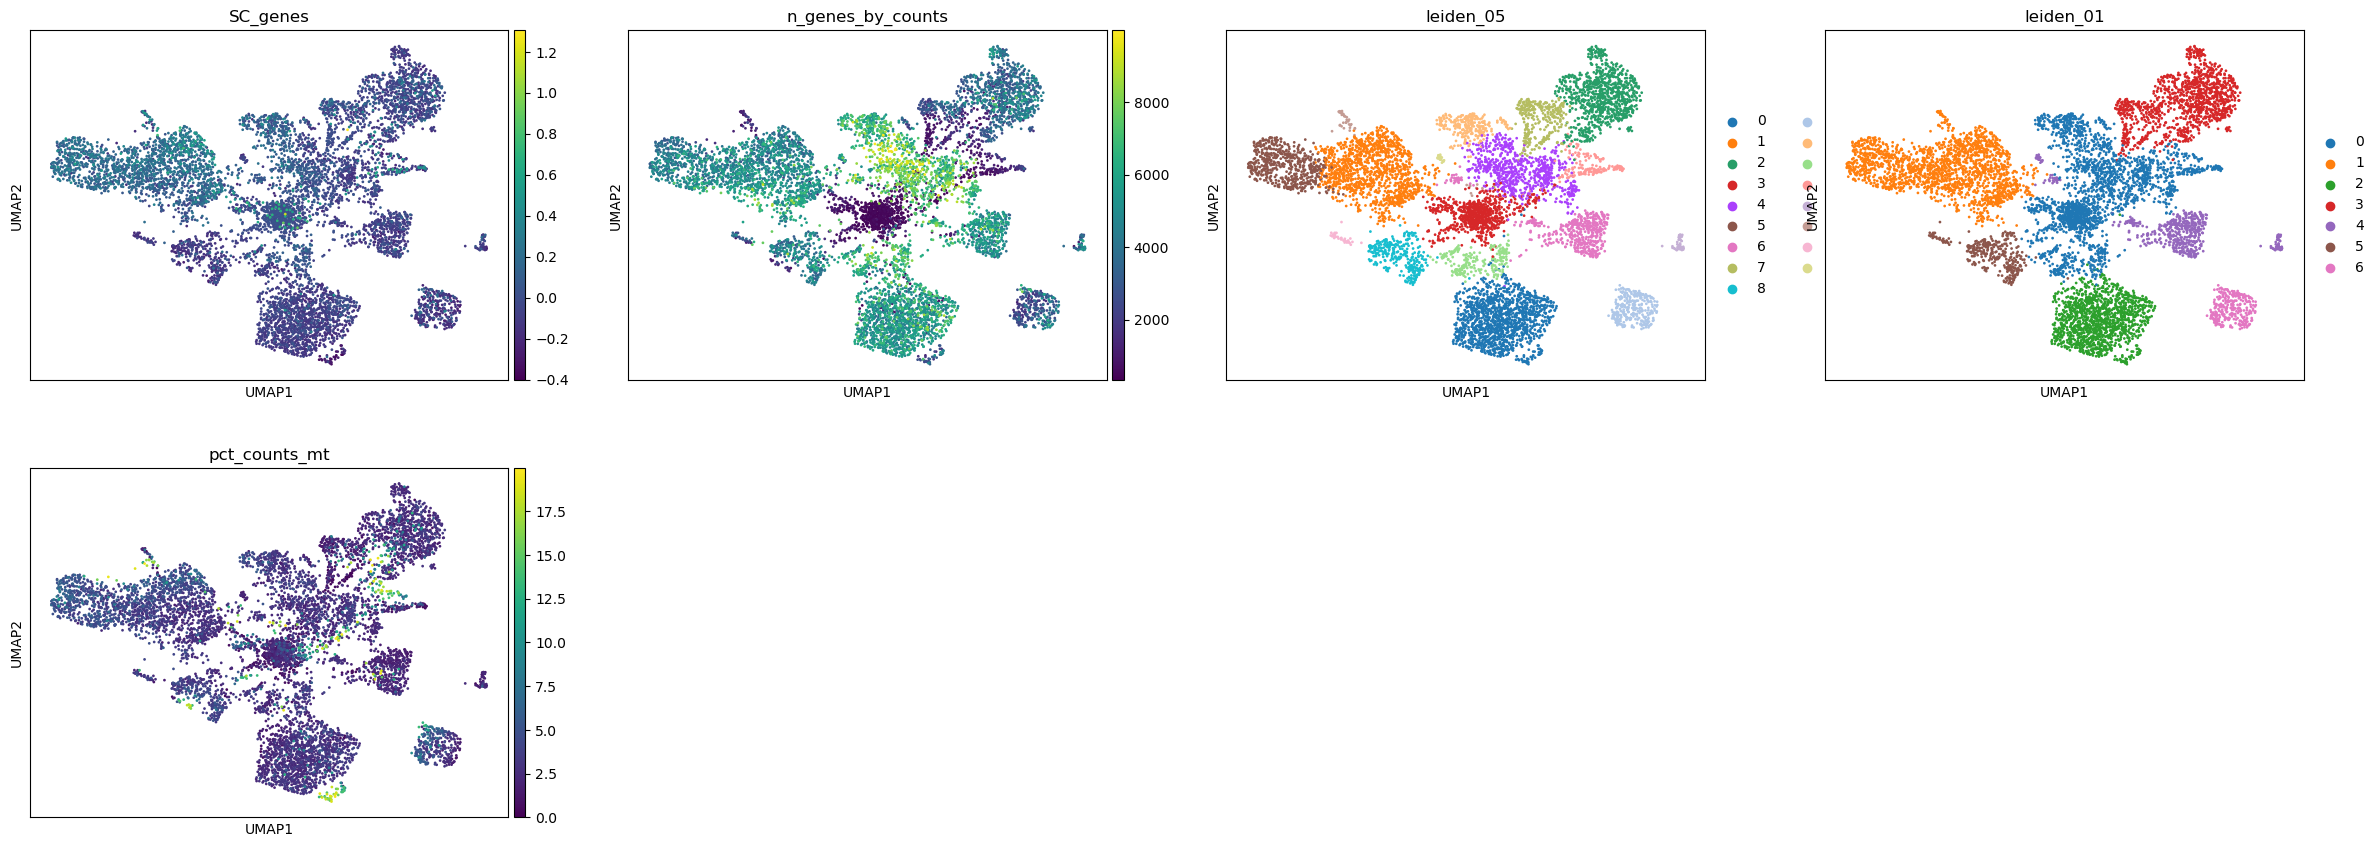

In [25]:
sc.pl.umap(adata,color = ["SC_genes", "n_genes_by_counts", "leiden_05", "leiden_01", "pct_counts_mt"])

In [21]:
adata_qc = adata[~adata.obs['leiden_05'].isin(["3"])]

Remove suspected soup

In [22]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata_qc, groupby="leiden_01", method="wilcoxon")

/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:639: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[

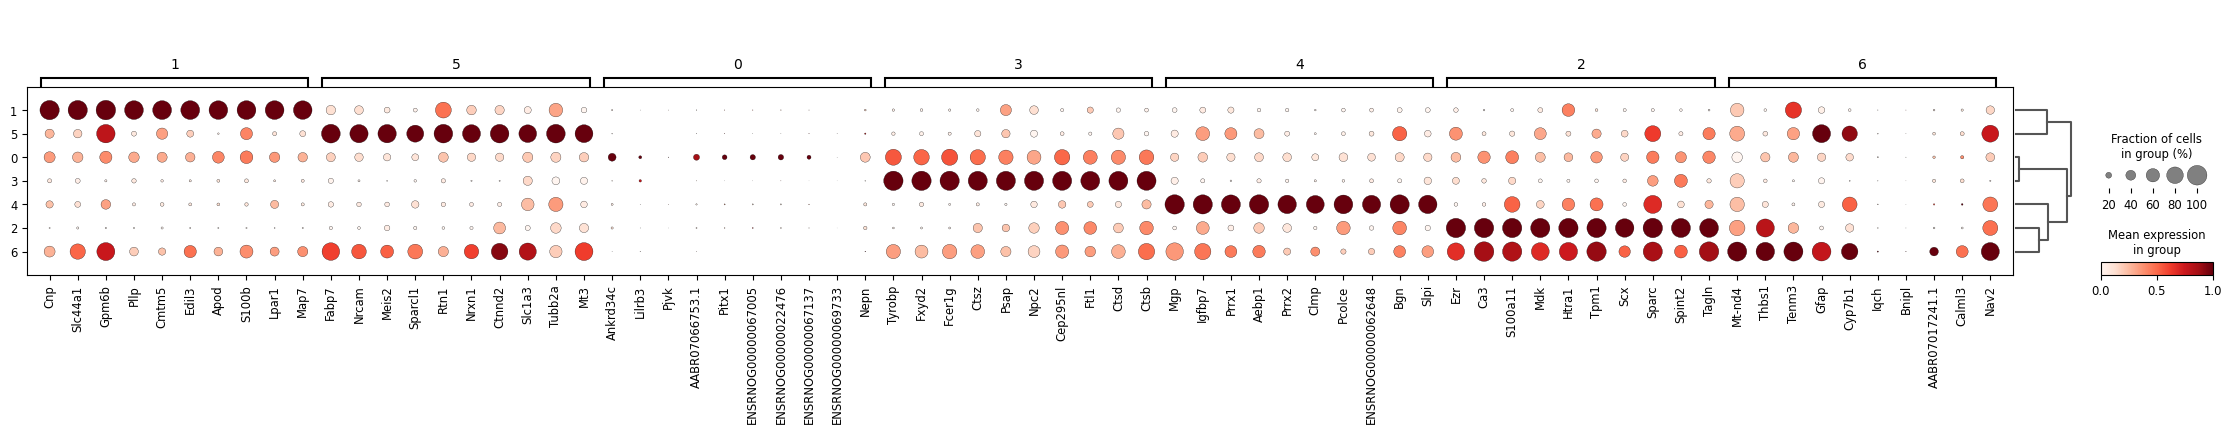

In [23]:
sc.pl.rank_genes_groups_dotplot(
    adata_qc, groupby="leiden_01", standard_scale="var", n_genes=10
)

In [24]:
sc.get.rank_genes_groups_df(adata_qc, group = None).to_csv("dt_out/2_invitro_analysis/TF_SC_filtered_feature_bc_matrix_preprocessed_clustering_DEG.csv")

In [26]:
adata_qc.write_h5ad("dt_out/2_invitro_analysis/TF_SC_filtered_feature_bc_matrix_preprocessed_clustered.h5ad")